In [2]:
import galsim
import tensorflow as tf
import tensorflow_hub as hub
from galaxy2galaxy import problems
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Load autoencoder model
encoder = hub.Module('modules/vae_cosmos_128/encoder')
decoder = hub.Module('modules/vae_cosmos_128/decoder')

In [3]:
# Load latent flow model
sampler = hub.Module('modules/latent_flow')

In [4]:
Modes = tf.estimator.ModeKeys
cosmos128 = problems.problem('attrs2img_cosmos128')
dset = cosmos128.dataset(Modes.EVAL, data_dir='/data2/g2g/datasets/attrs2img_cosmos128')
dset = dset.repeat().batch(128)
batch = dset.make_one_shot_iterator().get_next()


INFO:tensorflow:Reading data files from /data2/g2g/datasets/attrs2img_cosmos128/attrs2img_cosmos128-dev*
INFO:tensorflow:partition: 0 num_data_files: 1

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [7]:
code = encoder({'input': batch['inputs'], 'psf': batch['psf']})
samples = sampler({'flux_radius':batch['flux_radius'], 'zphot':batch['zphot'], 'mag_auto':batch['mag_auto']})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
# Assessing the distribution of codes
codes = []
params = []
codes_fake = []

for i in range(10):
    c,fr,tc = sess.run([samples, batch['mag_auto'], code])
    codes.append(tc.reshape((-1,32)))
    params.append(fr)
    codes_fake.append(c.reshape((-1,32)))
    
codes = concatenate(codes)
params = concatenate(params)
codes_fake = concatenate(codes_fake)

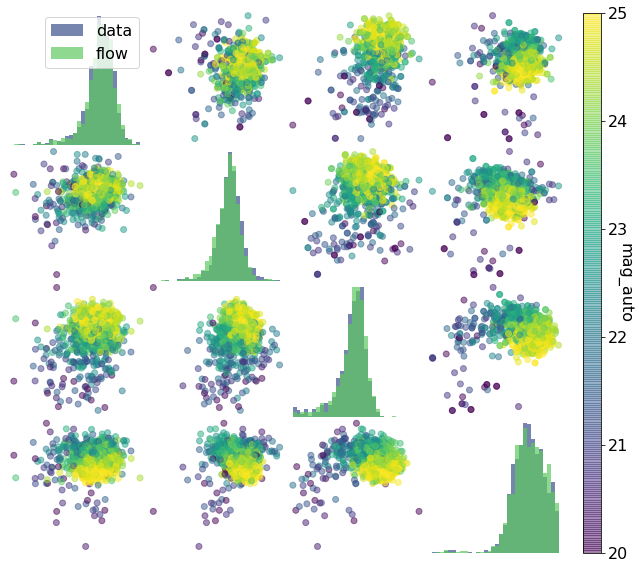

In [12]:
font = {'size'   : 16}

matplotlib.rc('font', **font)

fig = figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        subplot(4,4,i+j*4+1)
        if i < j:
            scatter(codes_fake[:,i], codes_fake[:,j], c=params, vmax=25, vmin=20, alpha=0.5); 
            axis('off')
        elif i > j:
            sc = scatter(codes[:,j], codes[:,i], c=params, vmax=25,vmin=20, alpha=0.5); 
            axis('off')
        else:
            hist(codes[:,i],32, range=[-5,5], alpha=0.7, label='data', color=plt.cm.viridis(0.25));
            hist(codes_fake[:,i], 32, range=[-5,5], alpha=0.7, label='flow', color=plt.cm.viridis(0.75));
            if i ==0:
                legend()
            axis('off')
subplots_adjust(wspace=0, hspace=0, right=0.9)
ax = fig.add_axes([0.925, 0.125, 0.025, 0.75])
cbar = fig.colorbar(sc, cax=ax);
cbar.set_label('mag_auto', rotation=270)
savefig('Figures/Figure_ConditionalFlow.pdf',bbox_inches='tight')